<a href="https://colab.research.google.com/github/CPeti/Spot-price-prediction/blob/peter-dev/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import periodogram, find_peaks, detrend

In [17]:
# import data from csv
data = pd.read_csv('./data/data_NO2.csv', sep=';')
data.head()

,datetime_utc,volume_demand,volume_production,spot_price
0,2015-12-31 23:00:00+00:00,4043.0,7818.0,16.39
1,2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04
2,2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74
3,2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57
4,2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47


In [18]:
data.describe()

,volume_demand,volume_production,spot_price
count,23666.000000,23666.000000,23666.000000
mean,4026.109186,5861.271867,30.891299
std,800.387150,1903.453922,9.601914
min,2490.000000,1082.000000,2.890000
25%,3373.000000,4449.000000,24.180000
50%,3875.000000,5605.000000,29.110000
75%,4648.000000,7411.750000,34.710000
max,6712.000000,9953.000000,114.700000


no missing values

In [19]:
# count the number of missing values in each column
missing_values = data.isnull().sum()
missing_values

datetime_utc         0
volume_demand        0
volume_production    0
spot_price           0
dtype: int64

In [20]:
# add calendar features
data['date'] = pd.to_datetime(data['datetime_utc'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek

In [21]:
# additional time features
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x > 4 else 0)
data['working_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 17 else 0)
data['night'] = data['hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0)
data['morning'] = data['hour'].apply(lambda x: 1 if 7 <= x <= 11 else 0)
data['afternoon'] = data['hour'].apply(lambda x: 1 if 12 <= x <= 16 else 0)
data['evening'] = data['hour'].apply(lambda x: 1 if 17 <= x <= 23 else 0)


In [22]:
# production and demand features
data['delta'] = data['volume_production'] - data['volume_demand']

# create a feature where we sum the previous days production values
data['volume_production_rolling'] = data['volume_production'].rolling(window=48).sum()
data['volume_demand_rolling'] = data['volume_demand'].rolling(window=48).sum()




In [23]:
# shift spot_price by 24 hours as target
data['target'] = data['spot_price'].shift(-24)

In [24]:
# Save processed data to csv
data.drop(columns=['datetime_utc', 'date']).to_csv('./data/data_NO2_processed.csv', index=False, sep=';')

In [25]:
# check correlation between features and target
# drop datetime_utc
data_ = data.drop(columns=['datetime_utc', 'date', 'spot_price'])
correlation = data_.corr()
correlation['target'].sort_values(ascending=False)

target                       1.000000
year                         0.666659
volume_production            0.101399
volume_demand                0.099505
working_hours                0.094767
delta                        0.087912
month                        0.081791
morning                      0.079679
week                         0.070881
hour                         0.046832
afternoon                    0.039247
volume_demand_rolling        0.031718
volume_production_rolling   -0.002349
evening                     -0.006977
day                         -0.007680
weekend                     -0.041984
dayofweek                   -0.054476
night                       -0.099276
Name: target, dtype: float64

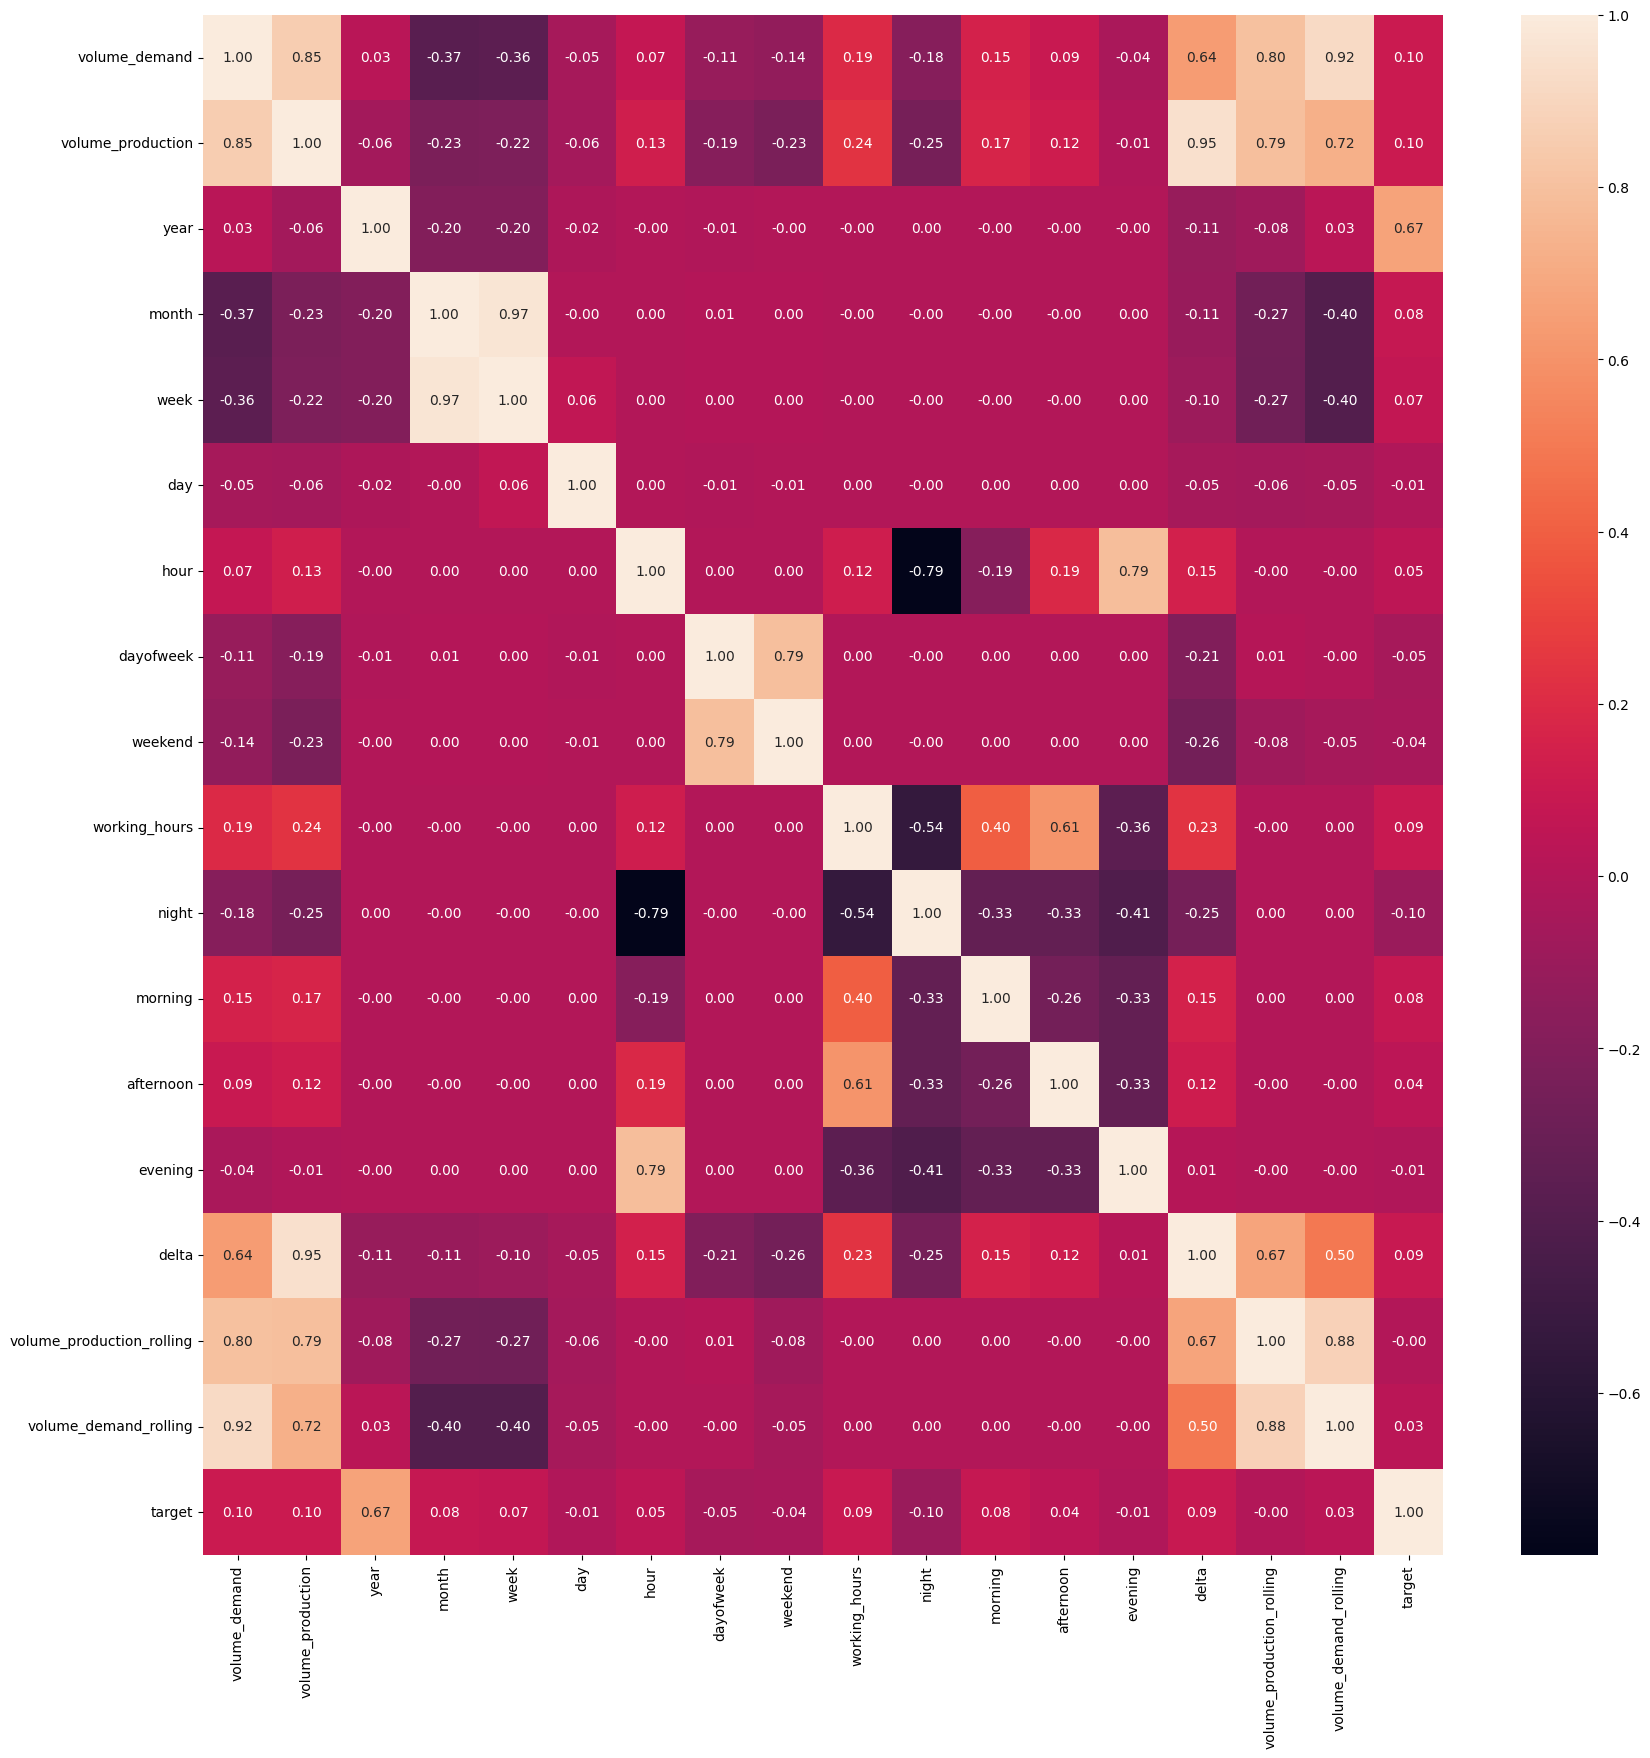

In [26]:
# correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.show()


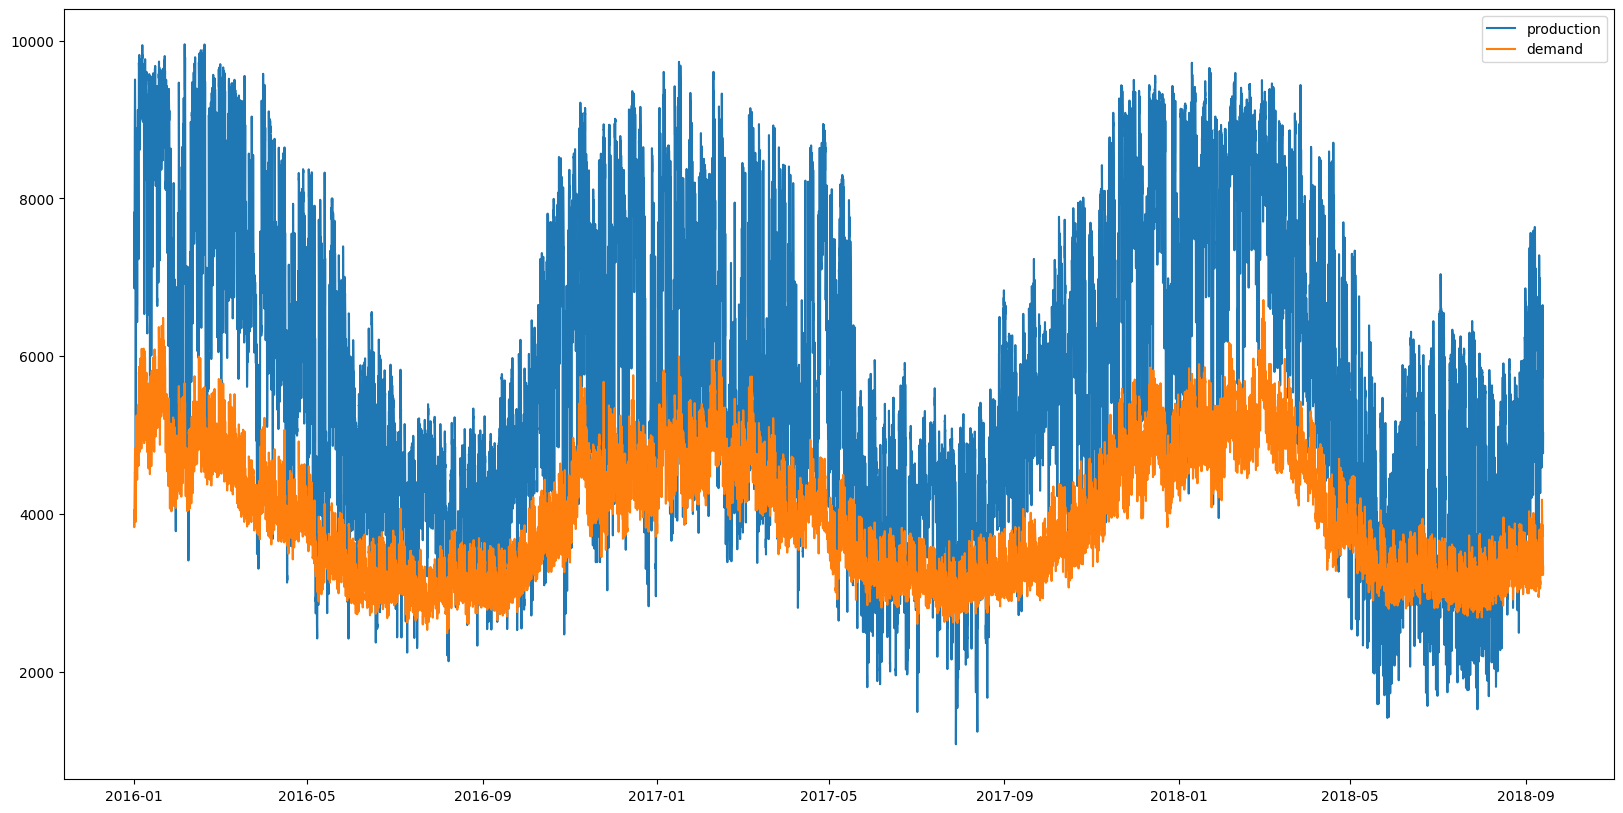

In [27]:
# plot production and demand
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['volume_production'], label='production')
plt.plot(data['date'], data['volume_demand'], label='demand')
# plot one year
#plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-12-31'))
plt.legend()

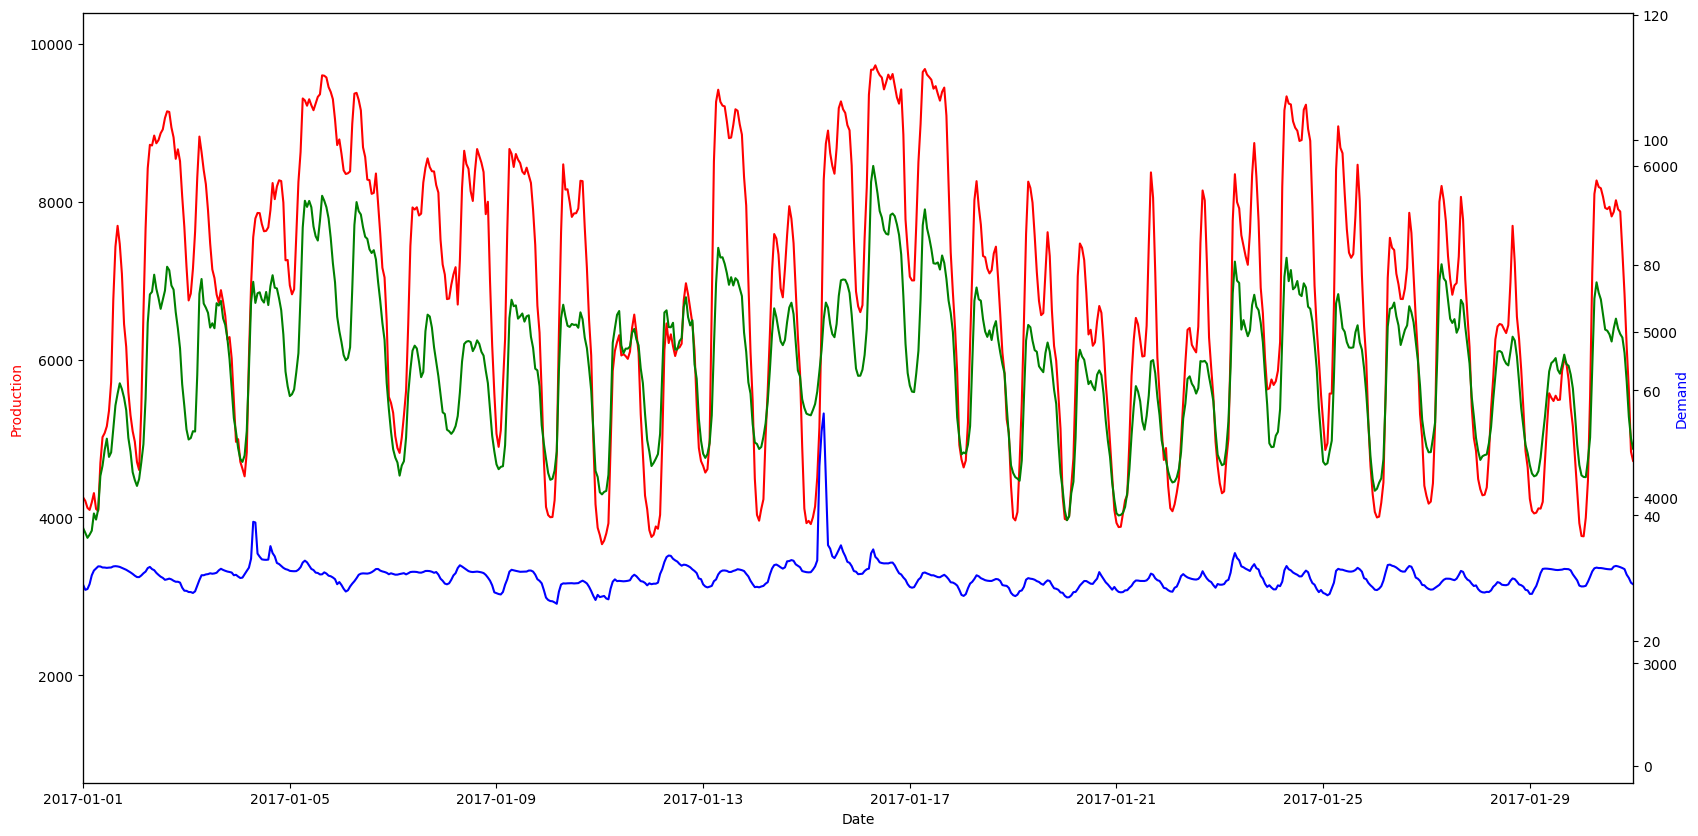

In [28]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(data['date'], data['volume_production'], 'r-')
ax2.plot(data['date'], data['target'], 'b-')
ax3.plot(data['date'], data['volume_demand'], 'g-')
ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))
ax2.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))
ax3.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))

ax1.set_xlabel('Date')
ax1.set_ylabel('Production', color='r')
ax2.set_ylabel('Demand', color='b')

plt.show()

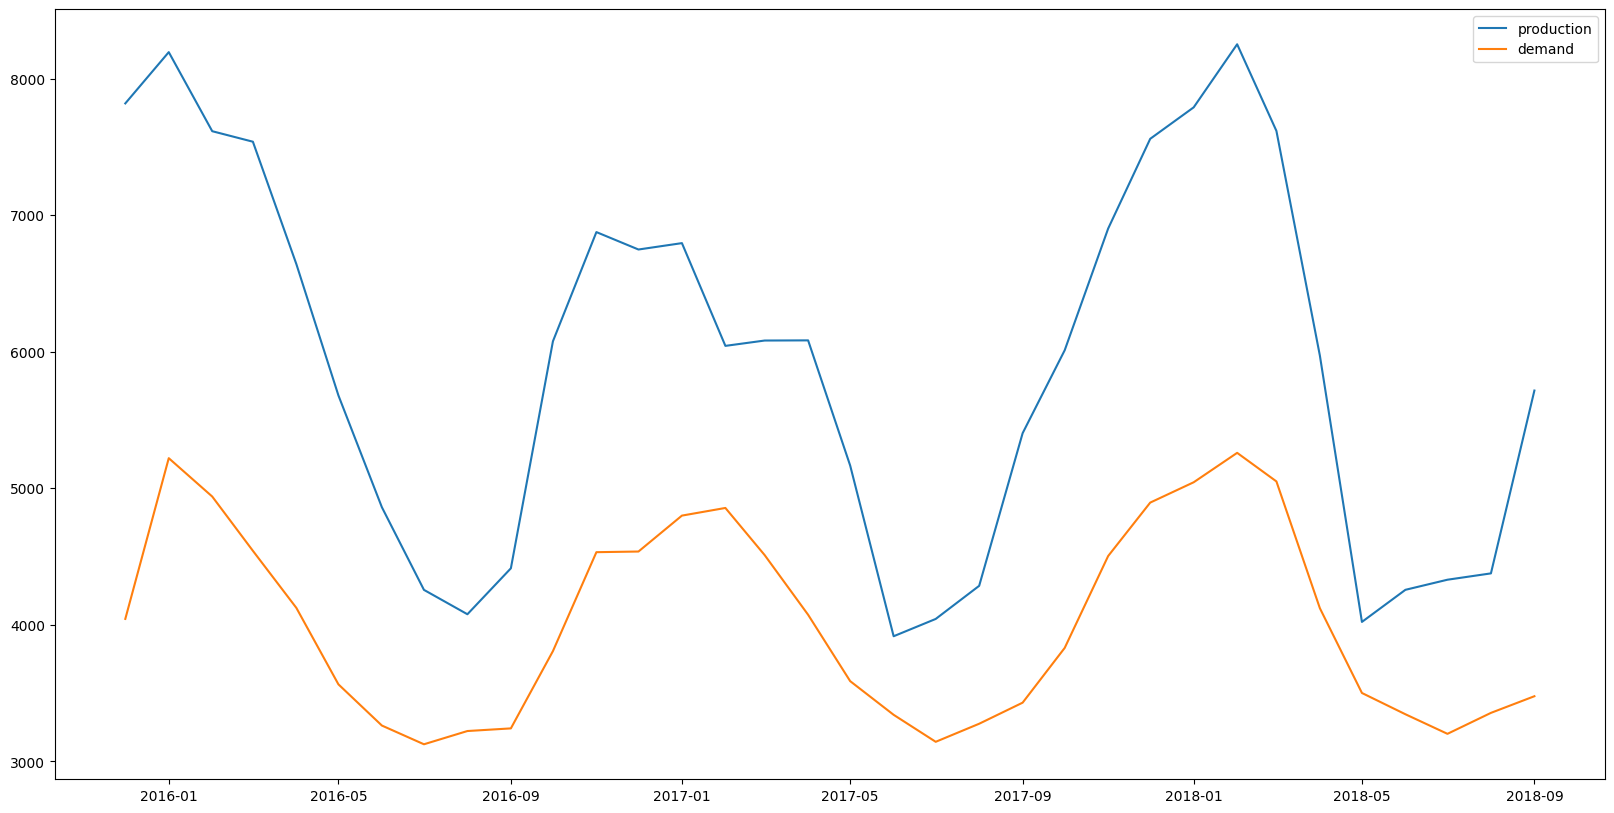

In [29]:
# calculate production and demand monthly averages
monthly = data.groupby(['year', 'month']).agg({'volume_production': 'mean', 'volume_demand': 'mean'}).reset_index()
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))
# plot production and demand monthly
plt.figure(figsize=(20, 10))
plt.plot(monthly['date'], monthly['volume_production'], label='production')
plt.plot(monthly['date'], monthly['volume_demand'], label='demand')
plt.legend()




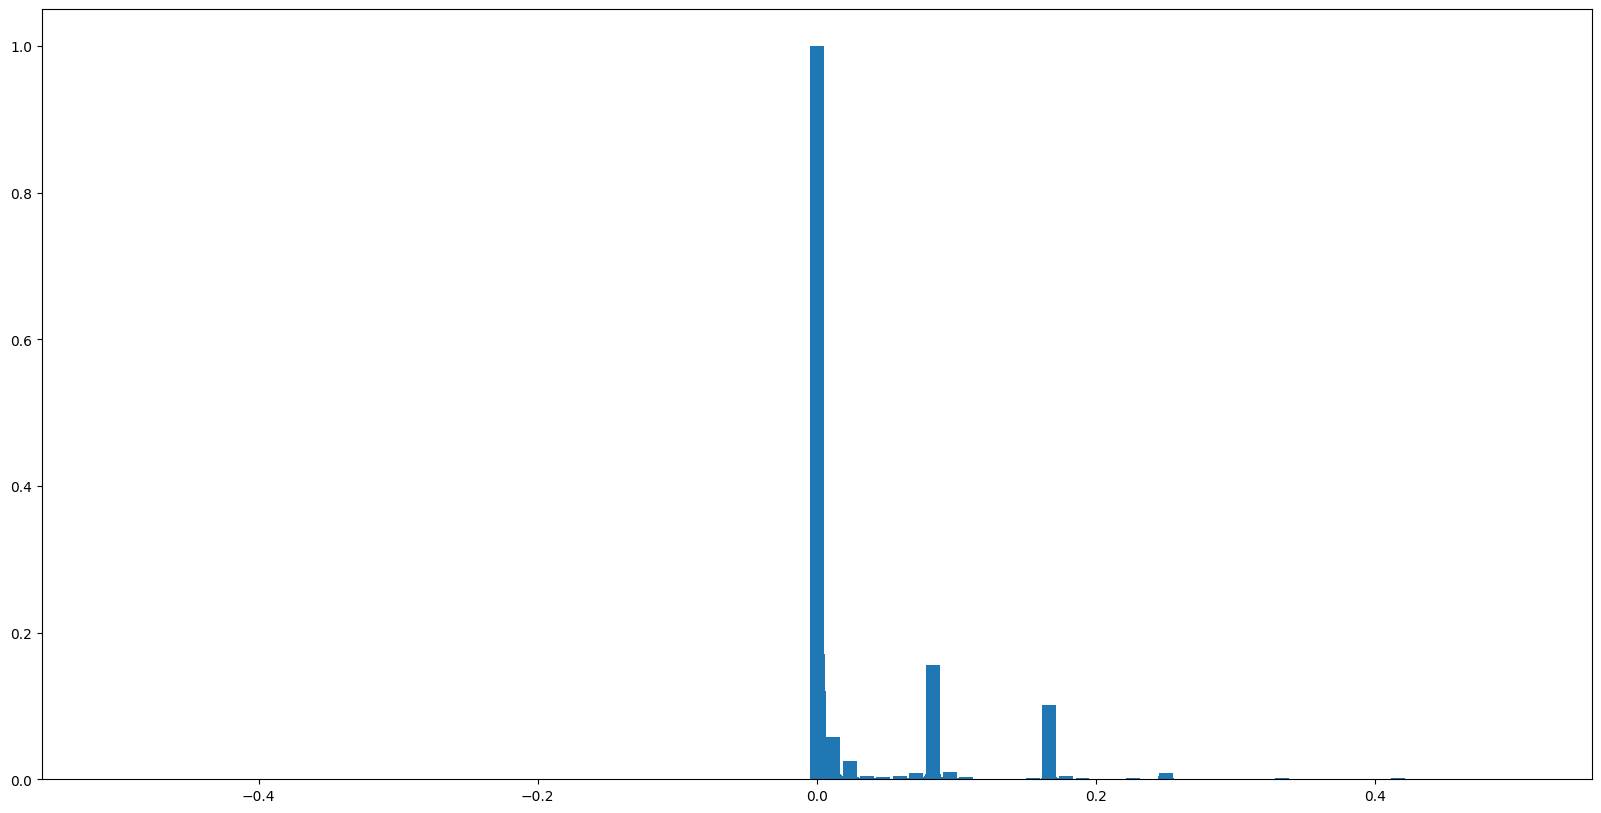

In [30]:
prices = data['spot_price']
prices = prices - prices.mean()
prices = detrend(prices)
prices = np.pad(prices, (0, 2 ** 16 - prices.shape[0]), 'constant')

sample_size = prices.shape[0]

FF = np.abs(np.fft.fft(prices) / sample_size) ** 2
P = (4 / sample_size) * FF[0:sample_size // 2]
f = np.fft.fftfreq(sample_size//2, 1)
P = P[1:] / P[1:].max()
peaks, _ = find_peaks(P, prominence=(0.004, 20.6), distance=20)


plt.figure(figsize=(20, 10))
plt.bar(f[1:], P, width=0.01)
plt.show()

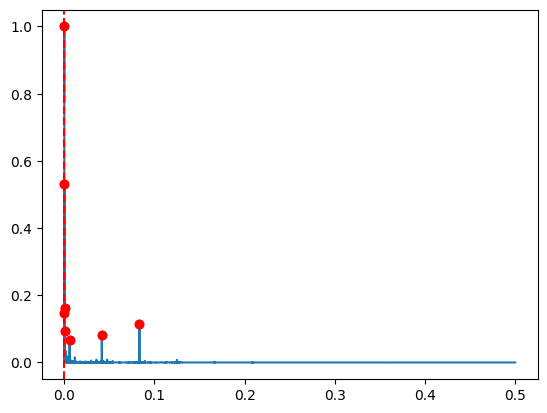

In [31]:
# create a periodogram
detrended_prices = detrend(data['spot_price'])
padded_prices = np.pad(detrended_prices, (0, 2000), 'constant')
f, Pxx = periodogram(padded_prices, fs=1, detrend=False)
periods = f[1:]
density = Pxx[1:] / Pxx[1:].max()
max_density_index = density.argmax()

period = periods[max_density_index]
peaks, _ = find_peaks(density, prominence=0.05)

plt.plot(periods, density)
plt.plot(periods[peaks], density[peaks], 'ro')
plt.plot(periods[peaks], density[peaks], 'ro')
plt.axvline(period, color='red', linestyle='--')
plt.show()



In [32]:
# create a list of (period, density) tuples for the peaks
peaks_tuple = [(np.round(1/periods[i])/24, density[peak]) for peak, i in enumerate(peaks)]
peaks_tuple.sort(key=lambda x: x[1], reverse=True)
peaks_tuple

[(213.875, 1.0),
 (534.7083333333334, 0.7774694054185496),
 (1.0, 0.5304679174543506),
 (48.625, 0.1469222179360586),
 (0.5, 0.13075216897880967),
 (97.20833333333333, 0.10294542698292289),
 (152.79166666666666, 0.08541496292829455),
 (7.0, 0.060250735088599704)]

In [33]:
peak_periods = 1 / periods[peaks]
tolerance = 0.1
whole_hour_periods = peak_periods[np.abs(peak_periods - np.round(peak_periods)) < tolerance]

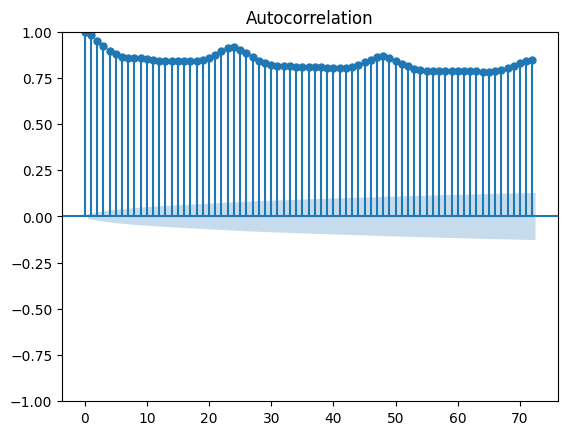

In [34]:
# create correlogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['spot_price'], lags=72)
plt.show()


ADF Statistic: -4.008970
p-value: 0.001364
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


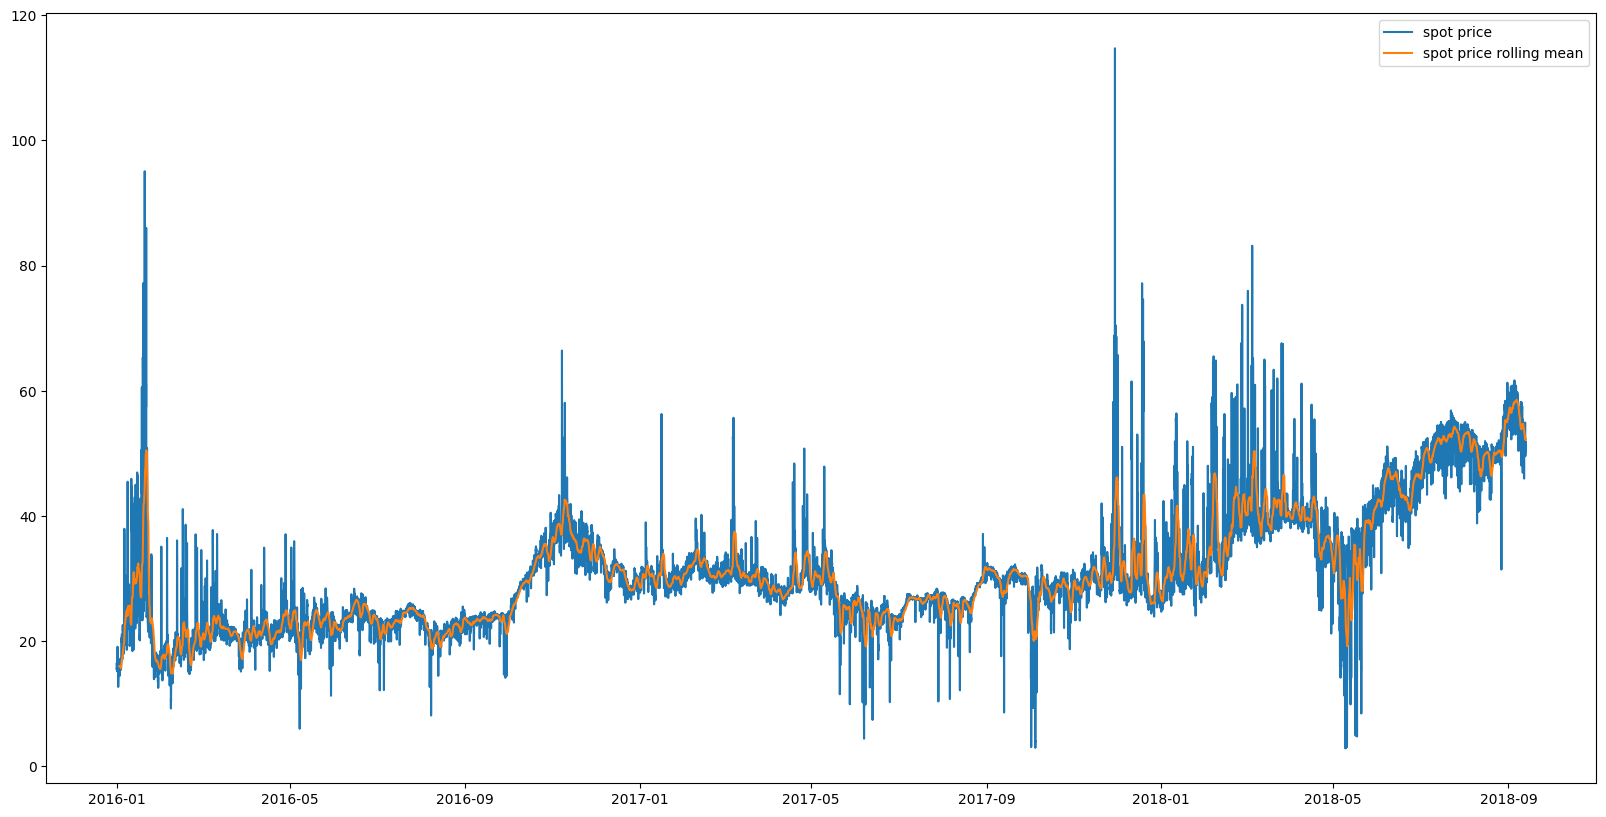

In [35]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['spot_price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# create a rolling mean and rolling standard deviation
data['spot_price_rolling'] = data['spot_price'].rolling(window=48).mean()
data['spot_price_std'] = data['spot_price'].rolling(window=48).std()

# plot spot price and rolling mean
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['spot_price'], label='spot price')
plt.plot(data['date'], data['spot_price_rolling'], label='spot price rolling mean')
plt.legend()




Text(0, 0.5, 'Demand')

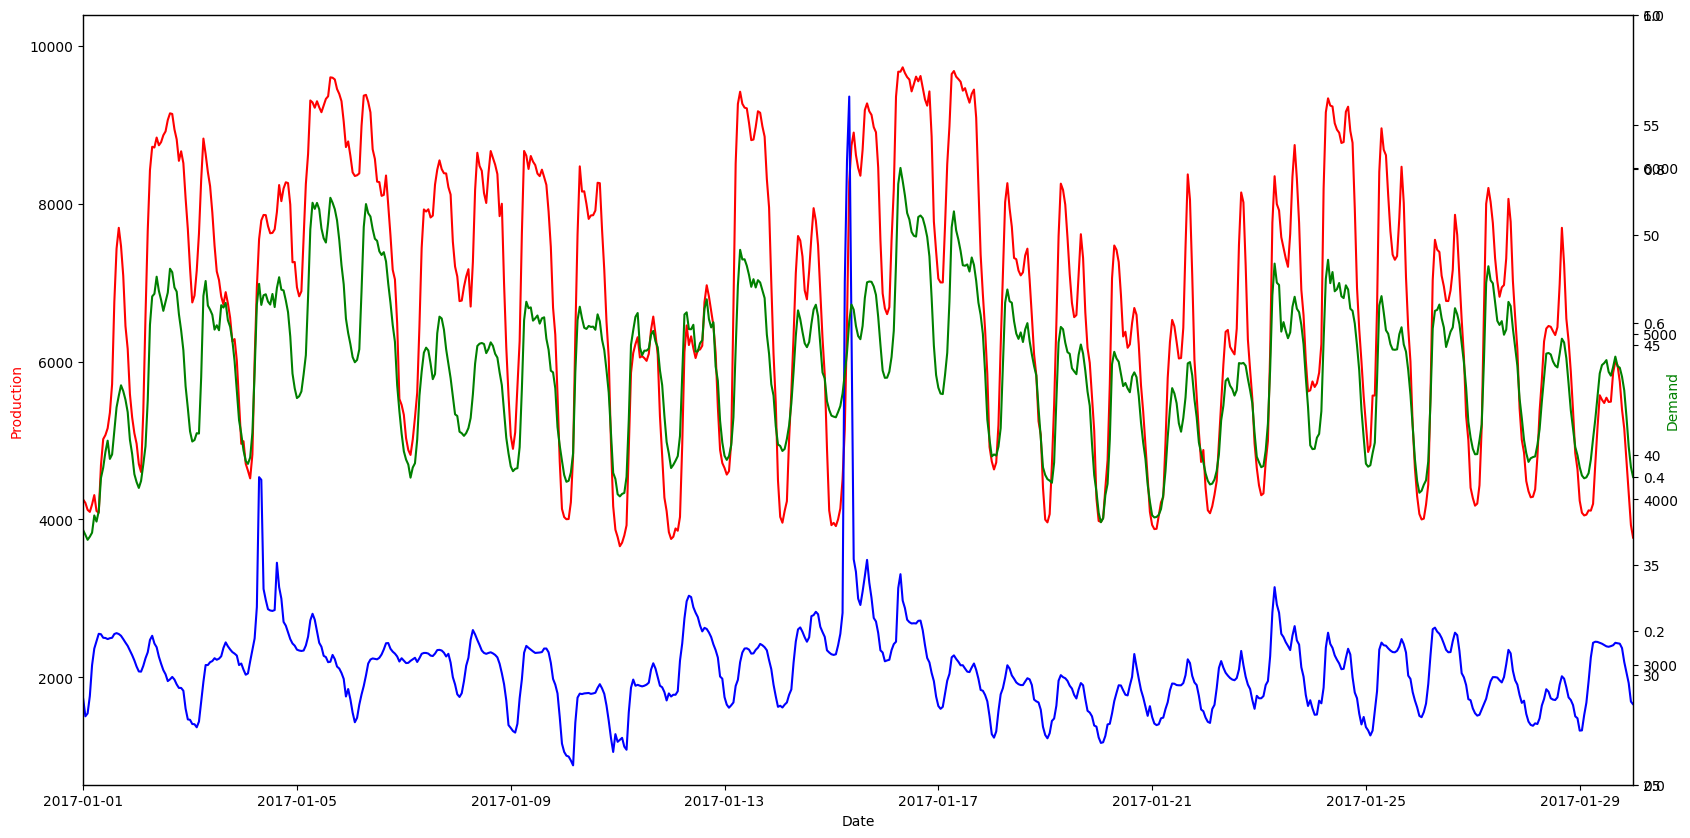

In [36]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

ax1.plot(data['date'], data['volume_production'], 'r-')
ax2.plot(data['date'], data['target'], 'b-')
ax3.plot(data['date'], data['volume_demand'], 'g-')
# plot delta

ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-30'))
ax2.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-30'))
ax2.set_ylim(25, 60)
ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-30'))

ax1.set_xlabel('Date')
ax1.set_ylabel('Production', color='r')
ax2.set_ylabel('Demand', color='g')


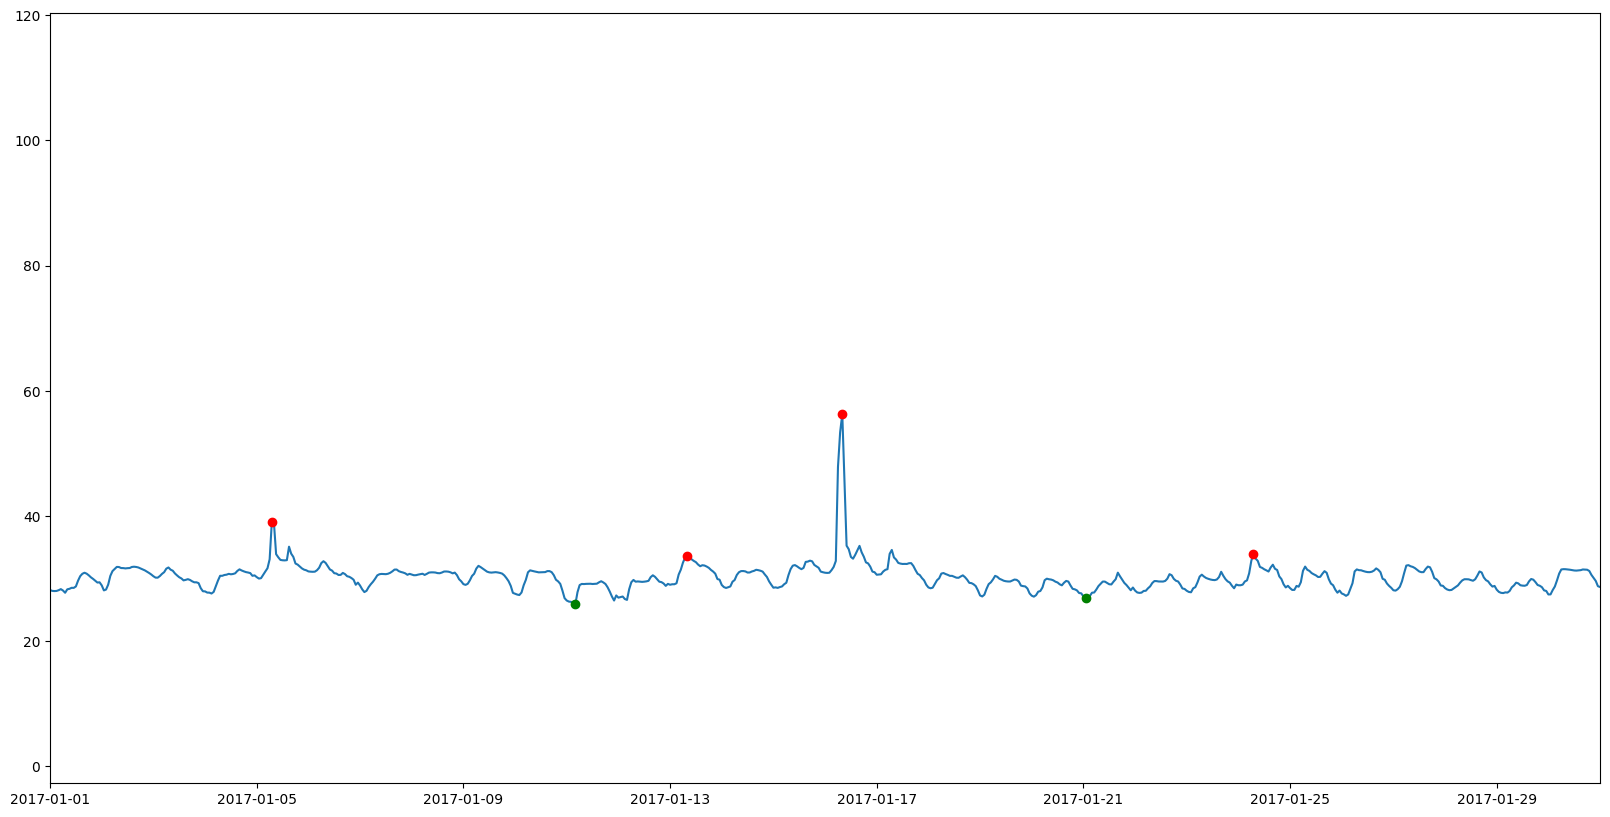

In [37]:
# plot one month of spot prices
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['spot_price'])
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))

#find peaks
peaks, _ = find_peaks(data['spot_price'], prominence=5)
# find low points
valleys, _ = find_peaks(-data['spot_price'], prominence=10)
plt.plot(data['date'][peaks], data['spot_price'][peaks], 'ro')
plt.plot(data['date'][valleys], data['spot_price'][valleys], 'go')
plt.show()


# Univariate analysis

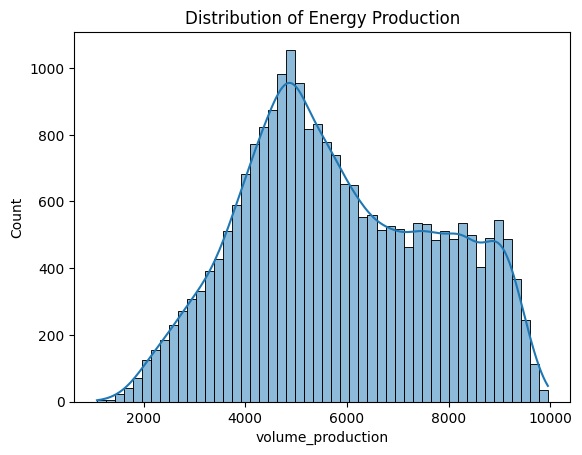

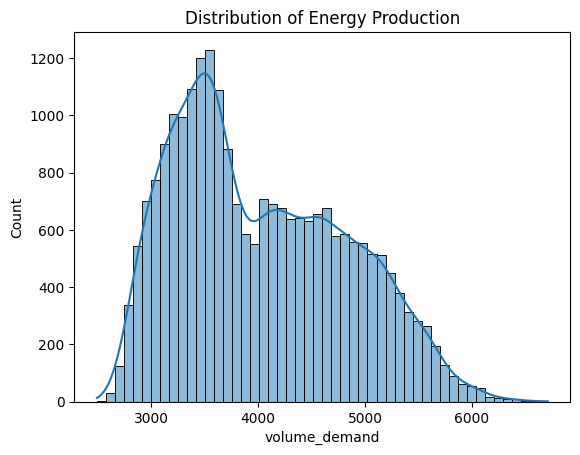

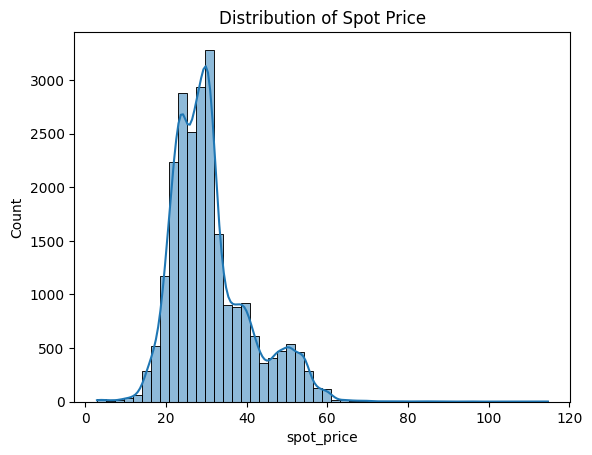

In [38]:
sns.histplot(data['volume_production'], bins=50, kde=True)
plt.title('Distribution of Energy Production')
plt.show()

sns.histplot(data['volume_demand'], bins=50, kde=True)
plt.title('Distribution of Energy Production')
plt.show()

sns.histplot(data['spot_price'], bins=50, kde=True)
plt.title('Distribution of Spot Price')
plt.show()

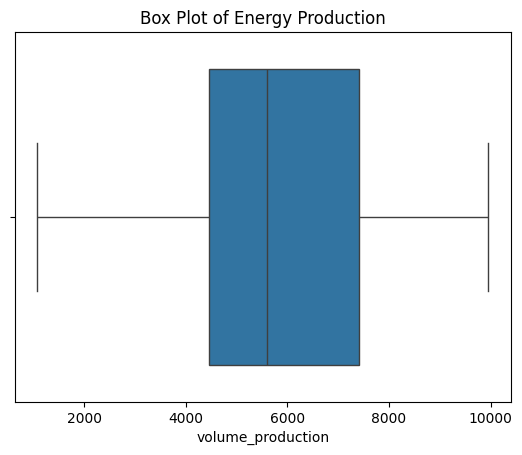

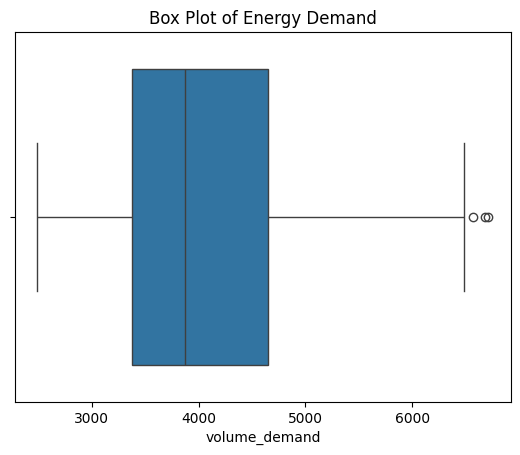

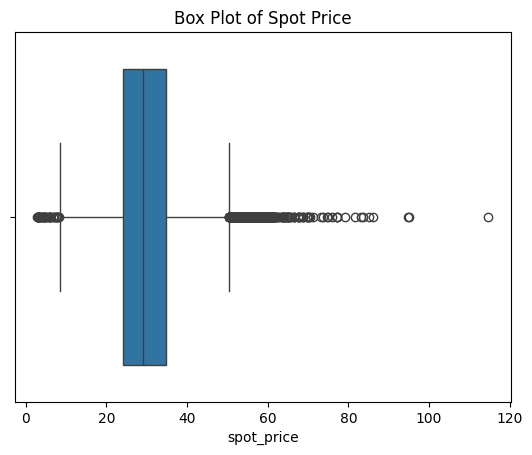

In [40]:
sns.boxplot(x=data['volume_production'])
plt.title('Box Plot of Energy Production')
plt.show()

sns.boxplot(x=data['volume_demand'])
plt.title('Box Plot of Energy Demand')
plt.show()

sns.boxplot(x=data['spot_price'])
plt.title('Box Plot of Spot Price')
plt.show()


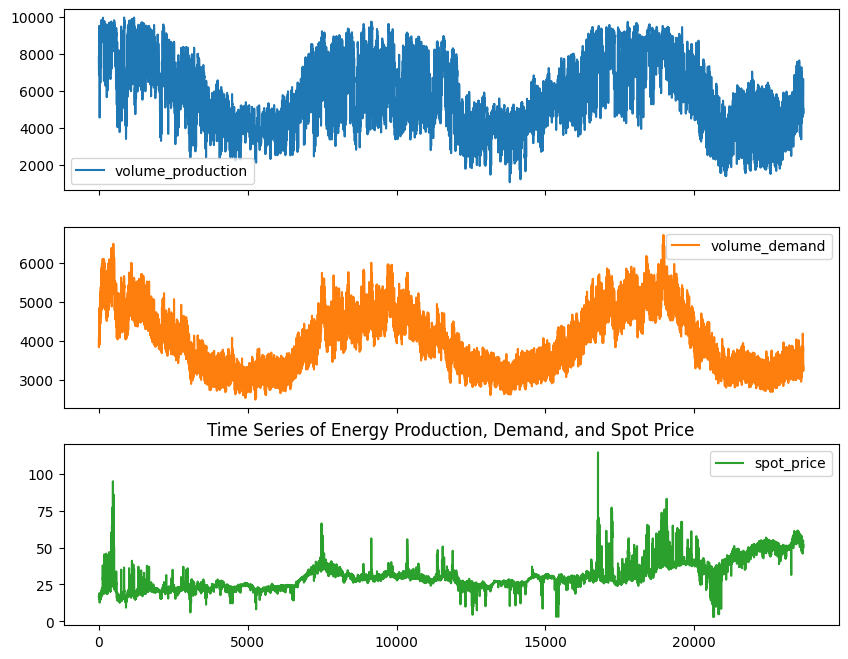

In [42]:
data[['volume_production', 'volume_demand', 'spot_price']].plot(subplots=True, figsize=(10, 8))
plt.title('Time Series of Energy Production, Demand, and Spot Price')
plt.show()


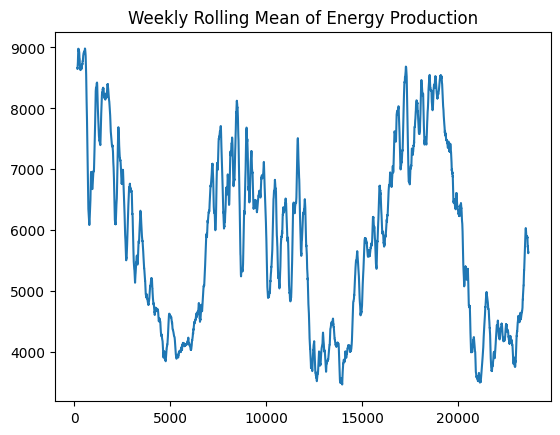

In [48]:
data['rolling_mean_production'] = data['volume_production'].rolling(window=24*7).mean()  # 24-hour window
data['rolling_mean_production'].plot()
plt.title('Weekly Rolling Mean of Energy Production')
plt.show()

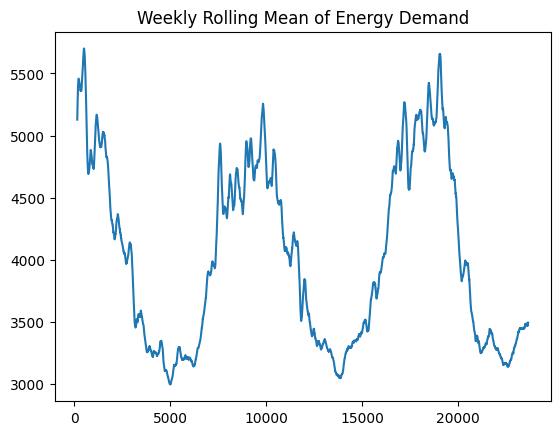

In [49]:
data['rolling_mean_demand'] = data['volume_demand'].rolling(window=24*7).mean()  # 24-hour window
data['rolling_mean_demand'].plot()
plt.title('Weekly Rolling Mean of Energy Demand')
plt.show()

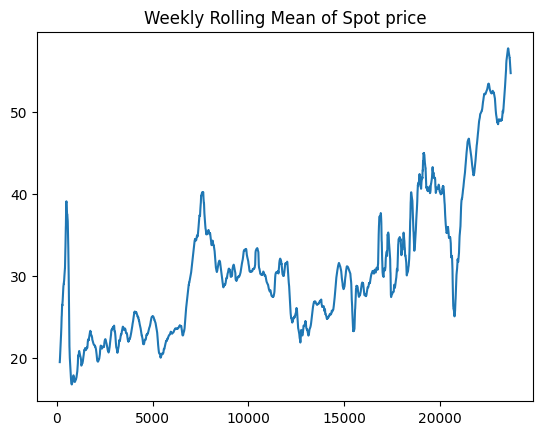

In [54]:
data['rolling_mean_spot_price'] = data['spot_price'].rolling(window=24*7).mean()  # 24-hour window
data['rolling_mean_spot_price'].plot()
plt.title('Weekly Rolling Mean of Spot price')
plt.show()

In [ ]:
sns.scatterplot(x='energy_production', y='spot_price', data=df)
plt.title('Energy Production vs Spot Price')
plt.show()

# Bivariate analysis

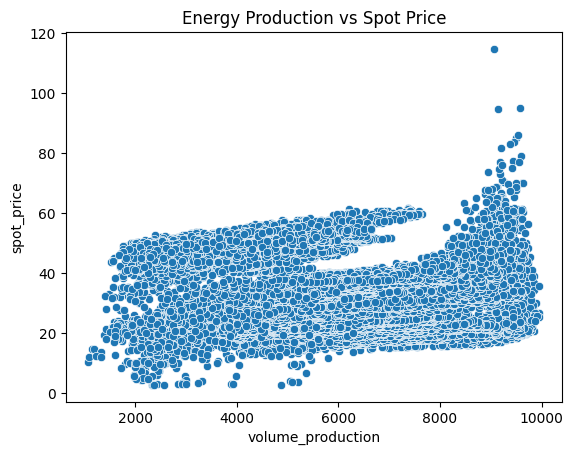

In [56]:
sns.scatterplot(x='volume_production', y='spot_price', data=data)
plt.title('Energy Production vs Spot Price')
plt.show()


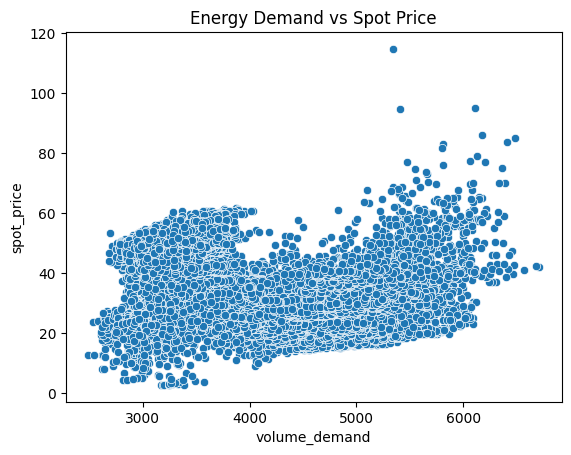

In [60]:
sns.scatterplot(x='volume_demand', y='spot_price', data=data)
plt.title('Energy Demand vs Spot Price')
plt.show()

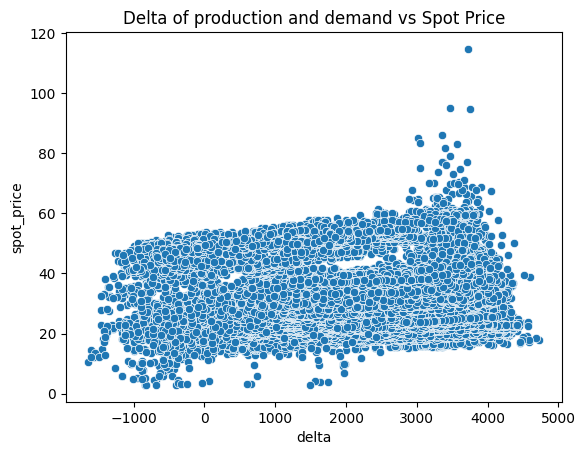

In [59]:
sns.scatterplot(x='delta', y='spot_price', data=data)
plt.title('Delta of production and demand vs Spot Price')
plt.show()

# Time series decomposition

i dont actually know what these do

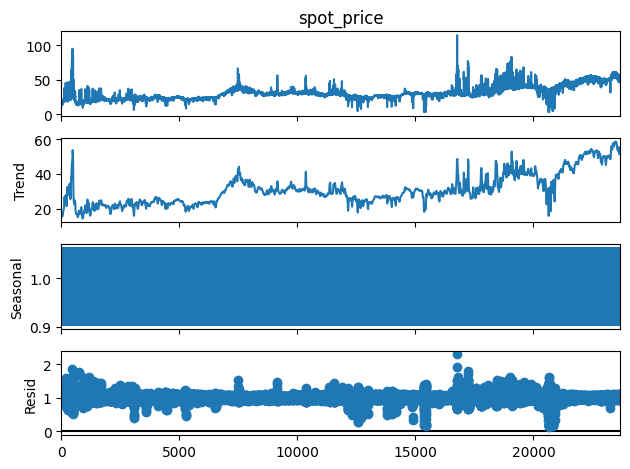

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['spot_price'], model='multiplicative', period=24)
decomposition.plot()
plt.show()

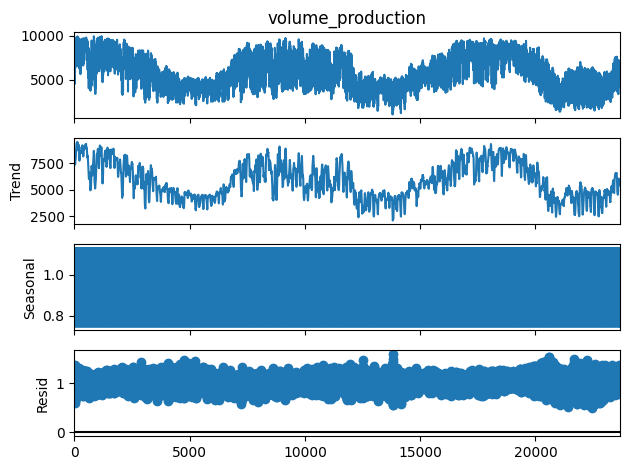

In [67]:
decomposition = seasonal_decompose(data['volume_production'], model='multiplicative', period=24)
decomposition.plot()
plt.show()

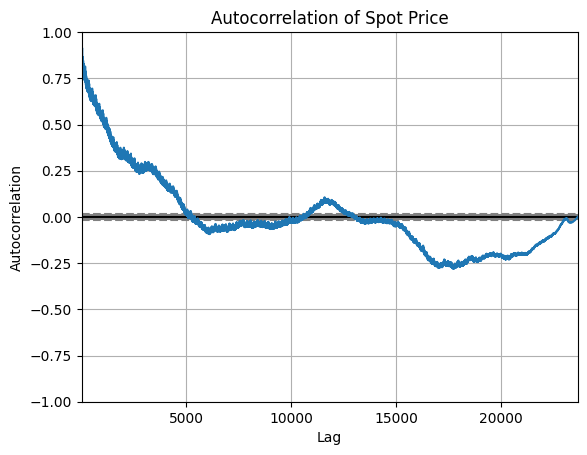

In [68]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['spot_price'])
plt.title('Autocorrelation of Spot Price')
plt.show()


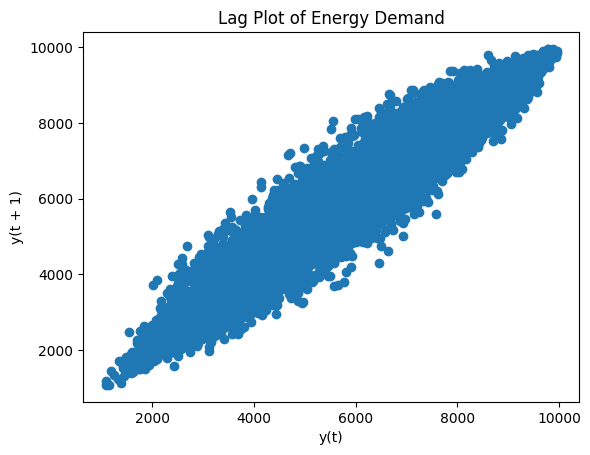

In [71]:
from pandas.plotting import lag_plot
lag_plot(data['volume_production'])
plt.title('Lag Plot of Energy Demand')
plt.show()

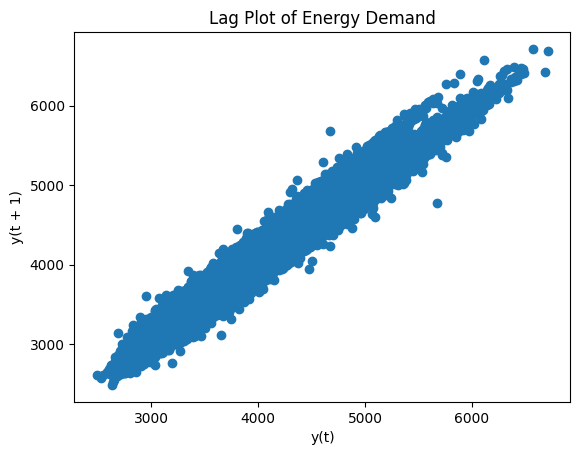

In [70]:
from pandas.plotting import lag_plot
lag_plot(data['volume_demand'])
plt.title('Lag Plot of Energy Demand')
plt.show()


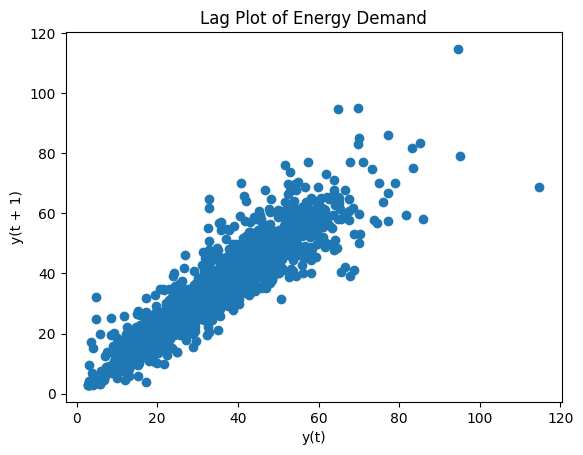

In [72]:
from pandas.plotting import lag_plot
lag_plot(data['spot_price'])
plt.title('Lag Plot of Energy Demand')
plt.show()

# Peaks

In [77]:
data.set_index('date', inplace=True)

C:\Users\pczum\AppData\Local\Temp\ipykernel_22472\1039434686.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hourly_avg = data.groupby('hour').mean()


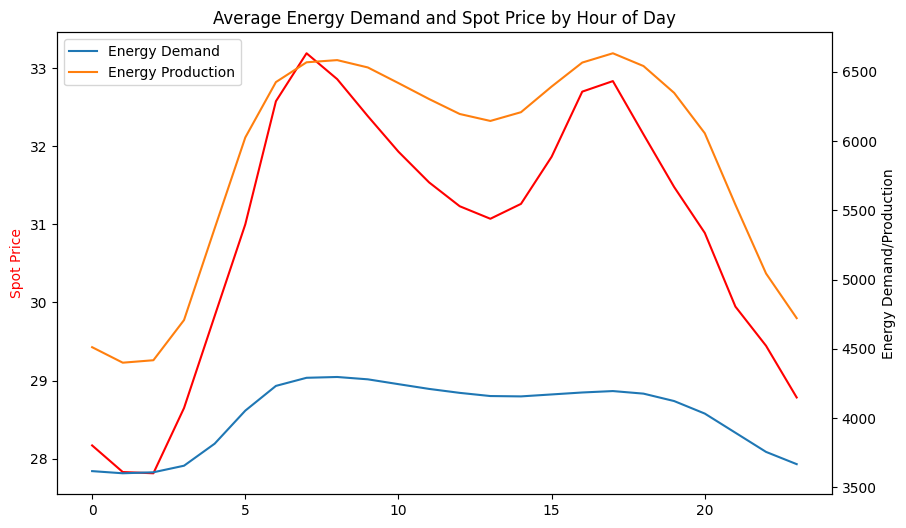

In [93]:
data['hour'] = data.index.hour
hourly_avg = data.groupby('hour').mean()
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(hourly_avg['spot_price'], color='red')
ax2.plot(hourly_avg[['volume_demand', 'volume_production']])
# legend
ax2.legend(['Energy Demand', 'Energy Production'])
# set labels
ax.set_ylabel('Spot Price', color='red')
ax2.set_ylabel('Energy Demand/Production')
plt.title('Average Energy Demand and Spot Price by Hour of Day')
plt.show()

C:\Users\pczum\AppData\Local\Temp\ipykernel_22472\3492364944.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_avg = data.groupby('day_of_week').mean()


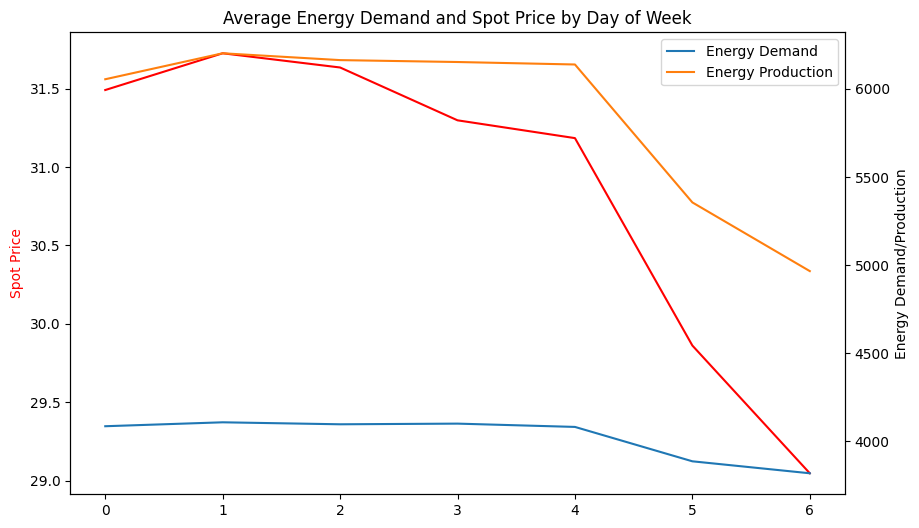

In [92]:
data['day_of_week'] = data.index.dayofweek
daily_avg = data.groupby('day_of_week').mean()
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(daily_avg['spot_price'], color='red')
ax2.plot(daily_avg[['volume_demand', 'volume_production']])
# legend
ax2.legend(['Energy Demand', 'Energy Production'])
# set labels
ax.set_ylabel('Spot Price', color='red')
ax2.set_ylabel('Energy Demand/Production')
plt.title('Average Energy Demand and Spot Price by Day of Week')
plt.show()


C:\Users\pczum\AppData\Local\Temp\ipykernel_22472\2515754391.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_avg = data.resample('M').mean()


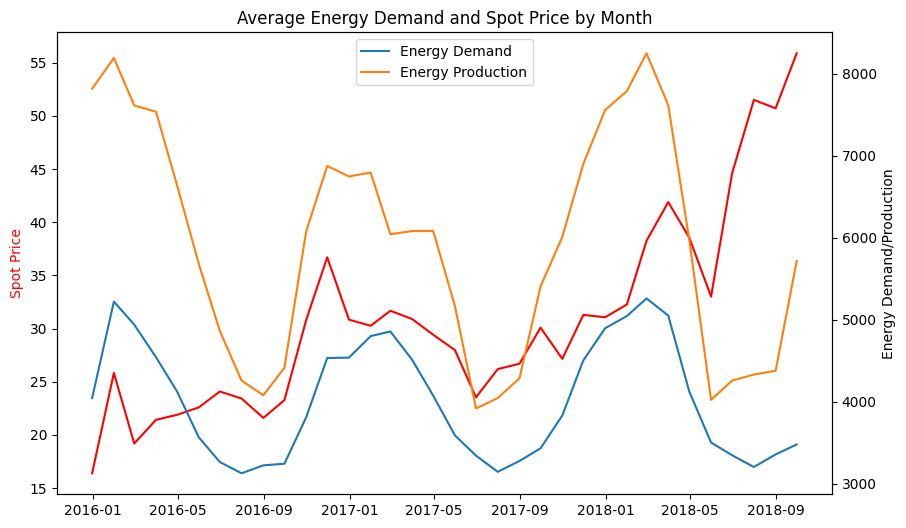

In [94]:
# monthly averages
monthly_avg = data.resample('M').mean()
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(monthly_avg['spot_price'], color='red')
ax2.plot(monthly_avg[['volume_demand', 'volume_production']])
# legend
ax2.legend(['Energy Demand', 'Energy Production'])
# set labels
ax.set_ylabel('Spot Price', color='red')
ax2.set_ylabel('Energy Demand/Production')
plt.title('Average Energy Demand and Spot Price by Month')
plt.show()  

In [130]:
effects = ['volume_demand', 'volume_production', 'spot_price']

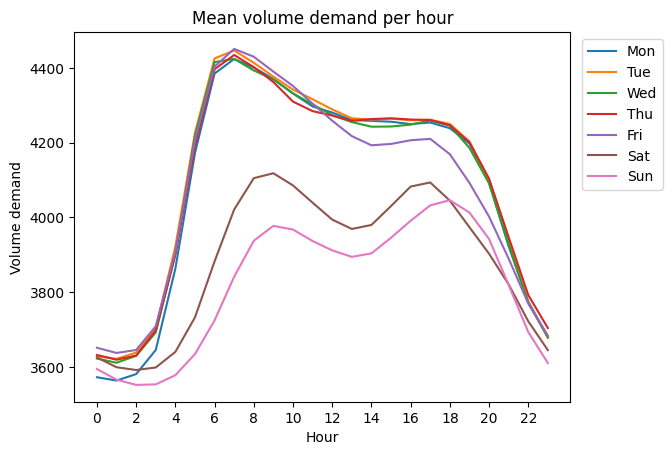

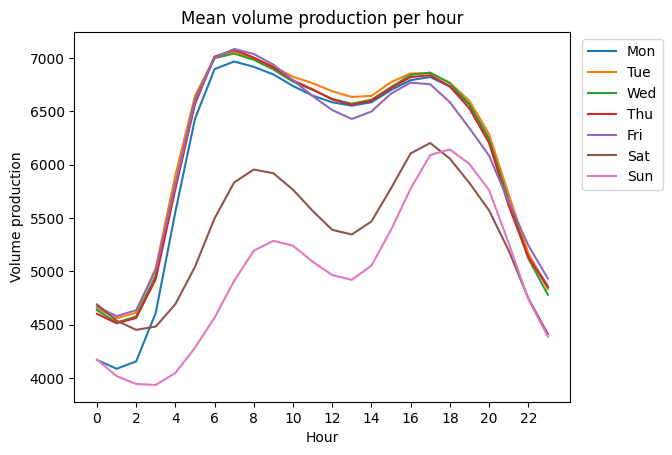

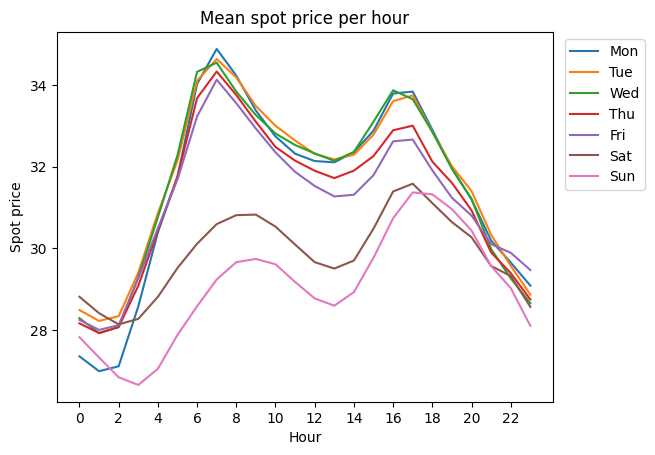

In [131]:
groups = ['dayofweek', 'hour']
hourly_data = data[effects + groups].groupby(groups).mean()
for var in effects:
    plt.plot(hourly_data.loc[0][var], label='Mon')
    plt.plot(hourly_data.loc[1][var], label='Tue')
    plt.plot(hourly_data.loc[2][var], label='Wed')
    plt.plot(hourly_data.loc[3][var], label='Thu')
    plt.plot(hourly_data.loc[4][var], label='Fri')
    plt.plot(hourly_data.loc[5][var], label='Sat')
    plt.plot(hourly_data.loc[6][var], label='Sun')

    pretty_name = var.replace('_', ' ')
    plt.title(f'Mean {pretty_name} per hour')
    plt.xlabel("Hour")
    plt.xticks(range(0, 23, 2))
    plt.ylabel(pretty_name.capitalize())
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

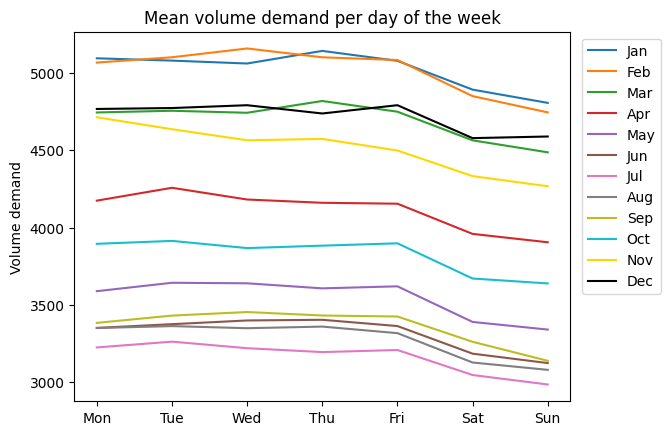

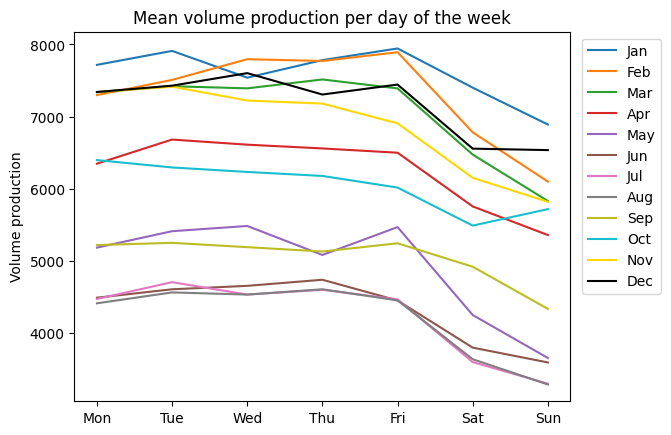

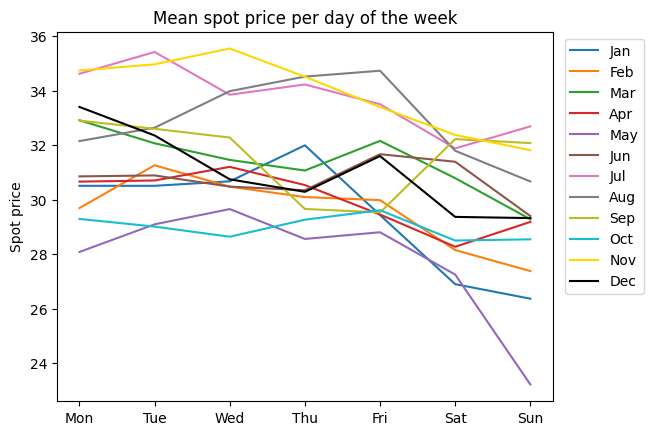

In [132]:
groups = ['month', 'dayofweek']
weekly_data = data[effects + groups].groupby(groups).mean()
for var in effects:
    plt.plot(weekly_data.loc[1][var], label='Jan')
    plt.plot(weekly_data.loc[2][var], label='Feb')
    plt.plot(weekly_data.loc[3][var], label='Mar')
    plt.plot(weekly_data.loc[4][var], label='Apr')
    plt.plot(weekly_data.loc[5][var], label='May')
    plt.plot(weekly_data.loc[6][var], label='Jun')
    plt.plot(weekly_data.loc[7][var], label='Jul')
    plt.plot(weekly_data.loc[8][var], label='Aug')
    plt.plot(weekly_data.loc[9][var], label='Sep')
    plt.plot(weekly_data.loc[10][var], label='Oct')
    plt.plot(weekly_data.loc[11][var], label='Nov', color='gold')
    plt.plot(weekly_data.loc[12][var], label='Dec', color='black')

    pretty_name = var.replace('_', ' ')
    plt.title(f'Mean {pretty_name} per day of the week')
    plt.xticks(range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.ylabel(pretty_name.capitalize())
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

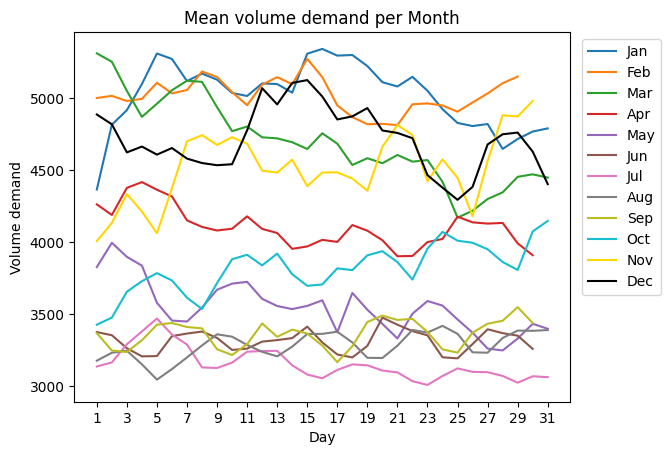

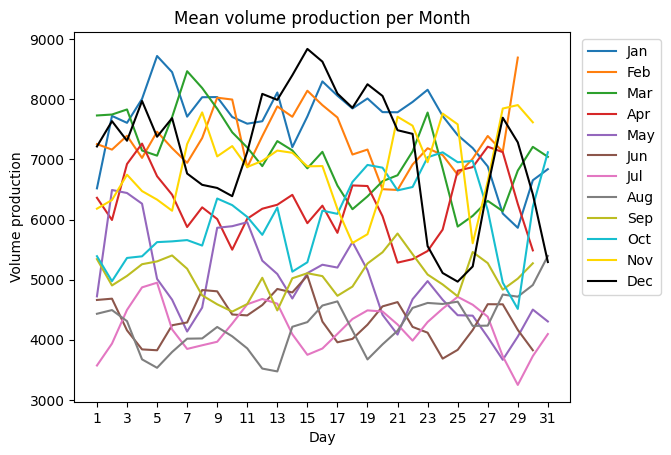

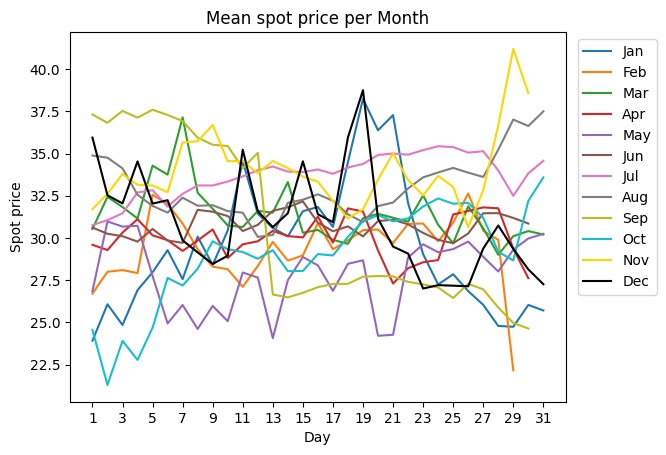

In [133]:
groups = ['month', 'day']
monthly_data = data[effects + groups].groupby(groups).mean()
for var in effects:
    plt.plot(monthly_data.loc[1][var], label='Jan')
    plt.plot(monthly_data.loc[2][var], label='Feb')
    plt.plot(monthly_data.loc[3][var], label='Mar')
    plt.plot(monthly_data.loc[4][var], label='Apr')
    plt.plot(monthly_data.loc[5][var], label='May')
    plt.plot(monthly_data.loc[6][var], label='Jun')
    plt.plot(monthly_data.loc[7][var], label='Jul')
    plt.plot(monthly_data.loc[8][var], label='Aug')
    plt.plot(monthly_data.loc[9][var], label='Sep')
    plt.plot(monthly_data.loc[10][var], label='Oct')
    plt.plot(monthly_data.loc[11][var], label='Nov', color='gold')
    plt.plot(monthly_data.loc[12][var], label='Dec', color='black')

    pretty_name = var.replace('_', ' ')
    plt.title(f'Mean {pretty_name} per Month')
    plt.xlabel('Day')
    plt.xticks(range(1, 32, 2))
    plt.ylabel(pretty_name.capitalize())
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

# Outlier detection

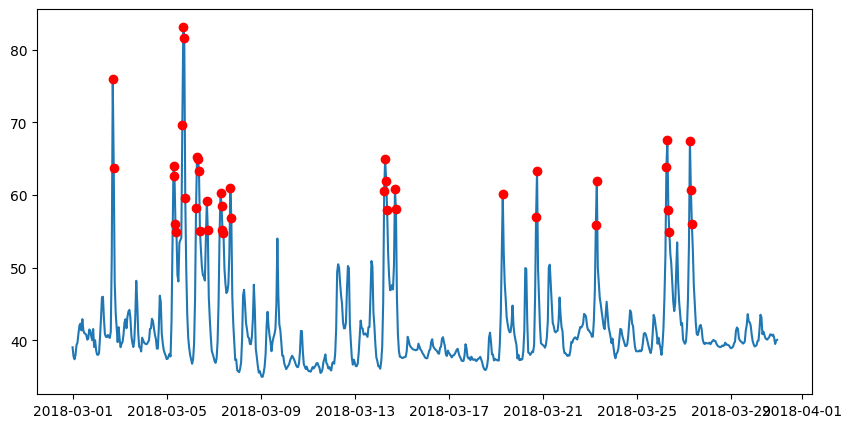

In [129]:
from scipy.stats import zscore
# calculate z-scores of one month of spot prices
data_month = data['spot_price'].loc['2018-03-01':'2018-03-30']
z_scores = zscore(data_month)
outliers = np.abs(z_scores) > 2

# plot spot prices with outliers
plt.figure(figsize=(10, 5))
plt.plot(data_month.index, data_month)
plt.plot(data_month.index[outliers], data_month[outliers], 'ro')
plt.show()


# Summary
todo